### Suggestions from Tutor
* Perhaps with SPY or other indices
* perform an hourly training/5 min traning, etc. 
* store pre-trained model 
* current data for prediction
* load model
* get ticker name input
* predict usining model
* show results

### Initial ML Attempt using LSTM RNN

_**Binary Keras LSTM model does not output binary predictions**_

"There is no 'binary' in neural networks, but a continuous function within limits.
Only with continuous functions a model can train and learn using "stochastic gradient descent".
For trying to achieve binary results, we use the sigmoid function, which goes from 0 to 1. But initially, your model is not trained, all its "weights" are sort of initialised randomly. 
The result is indeed results tending to mean values, which are 0.5 in sigmoid functions.
All you need is to train your model with enough data for enough epochs, 
so the results will gradually approach (but never hit) 0 or 1 (or whatever targets "y" you have in your training data)"

Source: https://stackoverflow.com/questions/46040656/binary-keras-lstm-model-does-not-output-binary-predictions

In [647]:
#Source: https://github.com/Derrick-Sherrill/DerrickSherrill.com/blob/master/stocks.py

import os
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
from path import Path
%matplotlib inline
from datetime import datetime as dt
from dateutil.tz import gettz
import re
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import keras
from newsapi import NewsApiClient
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from pathlib import Path
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#!pip install alpha_vantage
# get API from alpha vantage
api_key_stocks = os.getenv("ALPHA_VANTAGE_API_KEY")

#import nltk
#nltk.download()
from nltk.corpus import reuters
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Read your api key environment variable
api_key_news = os.getenv("NEWS_API_KEY")
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key_news)


In [648]:
# Read in data
data = Path("../Data/lnreturns_disney_nontrading.pickle")
df = pd.read_pickle(data)
df.head()

,text,compound,positive,negative,neutral,close,lagged_return_1d,lagged_return_3d,lagged_return_5d,return
date,,,,,,,,,,
2020-03-17,"Following several other movies, including Mula...",0.9963,0.107,0.040,0.853,93.53,0.0,0.000000,0.0,-0.015700
2020-03-18,It was supposed to launch alongside WarnerMedi...,0.9715,0.109,0.083,0.808,88.80,0.0,0.000000,0.0,-0.051896
2020-03-19,If your streaming queue is starting to look a ...,-0.8074,0.069,0.070,0.861,94.93,0.0,0.000000,0.0,0.066753
2020-03-20,Disney said on Friday that it is postponing th...,0.8507,0.045,0.036,0.919,85.98,0.0,-0.015700,0.0,-0.099025
2020-03-23,"If you decide to take advantage, keep in mind ...",0.9500,0.069,0.034,0.897,85.76,0.0,-0.051896,0.0,-0.002562


In [649]:
df.drop(columns = 'text', inplace=True)

In [650]:
df.head()

,compound,positive,negative,neutral,close,lagged_return_1d,lagged_return_3d,lagged_return_5d,return
date,,,,,,,,,
2020-03-17,0.9963,0.107,0.040,0.853,93.53,0.0,0.000000,0.0,-0.015700
2020-03-18,0.9715,0.109,0.083,0.808,88.80,0.0,0.000000,0.0,-0.051896
2020-03-19,-0.8074,0.069,0.070,0.861,94.93,0.0,0.000000,0.0,0.066753
2020-03-20,0.8507,0.045,0.036,0.919,85.98,0.0,-0.015700,0.0,-0.099025
2020-03-23,0.9500,0.069,0.034,0.897,85.76,0.0,-0.051896,0.0,-0.002562


In [651]:
df.tail()

,compound,positive,negative,neutral,close,lagged_return_1d,lagged_return_3d,lagged_return_5d,return
date,,,,,,,,,
2020-04-07,0.9745,0.068,0.035,0.897,101.24,-0.032589,0.021367,-3.206413,0.016533
2020-04-08,0.9789,0.056,0.018,0.926,101.07,-0.017544,-0.032384,-1.739130,-0.001681
2020-04-09,0.9773,0.093,0.057,0.850,104.50,0.021367,0.058944,2.159713,0.033374
2020-04-13,0.9912,0.103,0.047,0.849,103.50,-0.032384,0.016533,-3.186553,-0.009615
2020-04-14,0.9932,0.110,0.050,0.840,106.03,0.058944,-0.001681,6.071581,0.024150


In [652]:
df['Increase'] = (df['return'] >= 0).astype(int)
df.head()

,compound,positive,negative,neutral,close,lagged_return_1d,lagged_return_3d,lagged_return_5d,return,Increase
date,,,,,,,,,,
2020-03-17,0.9963,0.107,0.040,0.853,93.53,0.0,0.000000,0.0,-0.015700,0
2020-03-18,0.9715,0.109,0.083,0.808,88.80,0.0,0.000000,0.0,-0.051896,0
2020-03-19,-0.8074,0.069,0.070,0.861,94.93,0.0,0.000000,0.0,0.066753,1
2020-03-20,0.8507,0.045,0.036,0.919,85.98,0.0,-0.015700,0.0,-0.099025,0
2020-03-23,0.9500,0.069,0.034,0.897,85.76,0.0,-0.051896,0.0,-0.002562,0


In [653]:
df.Increase = df.Increase.astype('str')
df = pd.get_dummies(df, drop_first=True)
df.rename(columns={'Increase_1': 'Increase'}, inplace=True)
df.head()

,compound,positive,negative,neutral,close,lagged_return_1d,lagged_return_3d,lagged_return_5d,return,Increase
date,,,,,,,,,,
2020-03-17,0.9963,0.107,0.040,0.853,93.53,0.0,0.000000,0.0,-0.015700,0
2020-03-18,0.9715,0.109,0.083,0.808,88.80,0.0,0.000000,0.0,-0.051896,0
2020-03-19,-0.8074,0.069,0.070,0.861,94.93,0.0,0.000000,0.0,0.066753,1
2020-03-20,0.8507,0.045,0.036,0.919,85.98,0.0,-0.015700,0.0,-0.099025,0
2020-03-23,0.9500,0.069,0.034,0.897,85.76,0.0,-0.051896,0.0,-0.002562,0


In [654]:
df.dtypes

compound            float64
positive            float64
negative            float64
neutral             float64
close               float64
lagged_return_1d    float64
lagged_return_3d    float64
lagged_return_5d    float64
return              float64
Increase              uint8
dtype: object

In [655]:
#df.to_pickle('../Data/dis_dum.pickle')

In [656]:
# Read in data
#data = Path("../Data/lnreturns_disney_nontrading.pickle")
#df = pd.read_pickle(data)
#df.head()

In [657]:
#df.drop(columns = 'text', inplace=True)

In [658]:
#df.head()

In [659]:
#df.tail()

In [660]:
#df['Increase'] = (df['return'] >= 0).astype(int)
#df.head()

In [661]:
#df.Increase = df.Increase.astype('str')
#df = pd.get_dummies(df, drop_first=True)
#df.rename(columns={'Increase_1': 'Increase'}, inplace=True)
#df.head()

In [662]:
# df.dtypes()

In [663]:
#df.to_pickle('../Data/dis_ln_dum.pickle')

# Neural Network Sequential Model
## _Data Preparation_

In [664]:
# Create the features (X) and target (y) sets
X = df.iloc[:, 0:4].values
y = df["Increase"].values

In [665]:
X

array([[ 0.9963,  0.107 ,  0.04  ,  0.853 ],
       [ 0.9715,  0.109 ,  0.083 ,  0.808 ],
       [-0.8074,  0.069 ,  0.07  ,  0.861 ],
       [ 0.8507,  0.045 ,  0.036 ,  0.919 ],
       [ 0.95  ,  0.069 ,  0.034 ,  0.897 ],
       [ 0.9942,  0.093 ,  0.036 ,  0.872 ],
       [ 0.9952,  0.115 ,  0.053 ,  0.832 ],
       [ 0.3439,  0.066 ,  0.047 ,  0.887 ],
       [ 0.9948,  0.12  ,  0.047 ,  0.834 ],
       [ 0.722 ,  0.082 ,  0.085 ,  0.834 ],
       [ 0.9961,  0.092 ,  0.028 ,  0.88  ],
       [ 0.9927,  0.1   ,  0.046 ,  0.855 ],
       [ 0.9963,  0.123 ,  0.054 ,  0.823 ],
       [ 0.9963,  0.12  ,  0.047 ,  0.833 ],
       [ 0.9973,  0.125 ,  0.047 ,  0.828 ],
       [ 0.9745,  0.068 ,  0.035 ,  0.897 ],
       [ 0.9789,  0.056 ,  0.018 ,  0.926 ],
       [ 0.9773,  0.093 ,  0.057 ,  0.85  ],
       [ 0.9912,  0.103 ,  0.047 ,  0.849 ],
       [ 0.9932,  0.11  ,  0.05  ,  0.84  ]])

In [666]:
y

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1],
      dtype=uint8)

In [667]:
y= y.reshape(-1,1)
y.shape

(20, 1)

In [668]:
X.shape

(20, 4)

## _Model Fitting_

In [669]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [670]:
# Creating training and testing data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False) 

In [671]:
# Define the model - shallow neural net
number_hidden_nodes = 8
number_input_features = 4

nn = Sequential()
# Hidden layer
nn.add(
    Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="sigmoid") # look like a call option
)
# Output layer
nn.add(Dense(units=1, activation="tanh")) # output activation should somehow match the 

In [672]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
nn.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 8)                 40        
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 9         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [673]:
# Creating validation data sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False) 

In [674]:
# Train the model
model_1 = nn.fit(X_train, y_train, shuffle=False, validation_data=(X_val, y_val), batch_size=1, epochs=200)

Train on 9 samples, validate on 5 samples
Epoch 1/200
9/9 [==============================] - 0s 30ms/sample - loss: 0.4886 - mse: 0.4886 - val_loss: 0.4468 - val_mse: 0.4468
Epoch 2/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.4603 - mse: 0.4603 - val_loss: 0.4251 - val_mse: 0.4251
Epoch 3/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.4348 - mse: 0.4348 - val_loss: 0.4057 - val_mse: 0.4057
Epoch 4/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.4122 - mse: 0.4122 - val_loss: 0.3888 - val_mse: 0.3888
Epoch 5/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.3922 - mse: 0.3922 - val_loss: 0.3741 - val_mse: 0.3741
Epoch 6/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.3746 - mse: 0.3746 - val_loss: 0.3614 - val_mse: 0.3614
Epoch 7/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.3593 - mse: 0.3593 - val_loss: 0.3504 - val_mse: 0.3504
Epoch 8/200
9/9 [=======================

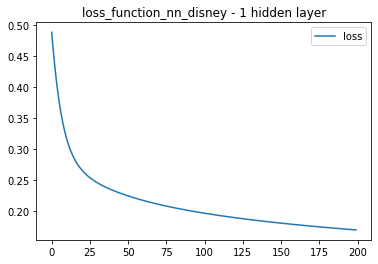

In [675]:
# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function_nn_disney - 1 hidden layer")
plt.legend(["loss"])
plt.savefig('../Images/loss_function_nn_disney - 1 hidden layer.png')
plt.show()

In [676]:
import h5py

nn.save('../Models/disney_nn_loss_1_layer.h5')  # creates a HDF5 file 'my_model.h5'
del nn  # deletes the existing model

### Add Another Layer

In [677]:
# Define the model - deep neural net
number_input_features = 4
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 4

nn = Sequential()
# First hidden layer
nn.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid")
)
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="tanh"))
# Output layer
nn.add(Dense(units=1, activation="linear"))

In [678]:
# Compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
nn.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 8)                 40        
_________________________________________________________________
dense_193 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_194 (Dense)            (None, 1)                 5         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [679]:
# Creating validation data sets
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False) 

In [680]:
# Fit the model
model_2 = nn.fit(X_train, y_train, shuffle=False, validation_data=(X_val, y_val), batch_size=1, epochs=200)

Train on 9 samples, validate on 5 samples
Epoch 1/200
9/9 [==============================] - 0s 33ms/sample - loss: 1.4334 - mse: 1.4334 - val_loss: 1.1242 - val_mse: 1.1242
Epoch 2/200
9/9 [==============================] - 0s 2ms/sample - loss: 1.2053 - mse: 1.2053 - val_loss: 0.9333 - val_mse: 0.9333
Epoch 3/200
9/9 [==============================] - 0s 2ms/sample - loss: 1.0099 - mse: 1.0099 - val_loss: 0.7717 - val_mse: 0.7717
Epoch 4/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.8444 - mse: 0.8444 - val_loss: 0.6383 - val_mse: 0.6383
Epoch 5/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.7072 - mse: 0.7072 - val_loss: 0.5306 - val_mse: 0.5306
Epoch 6/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.5954 - mse: 0.5954 - val_loss: 0.4454 - val_mse: 0.4454
Epoch 7/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.5060 - mse: 0.5060 - val_loss: 0.3794 - val_mse: 0.3794
Epoch 8/200
9/9 [=======================

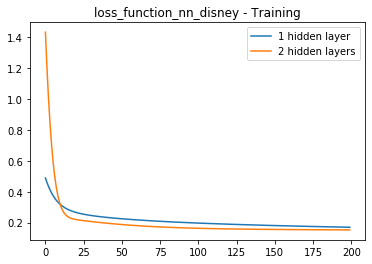

In [681]:
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.title("loss_function_nn_disney - Training")
plt.legend(["1 hidden layer", "2 hidden layers"])
plt.savefig('../Images/loss_function_nn_disney - Training.png')
plt.show()

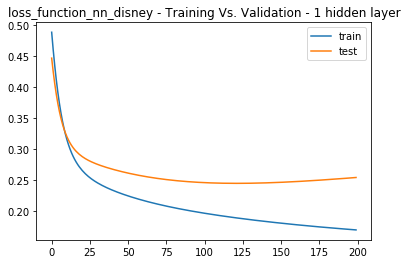

In [682]:
# Train vs test for shallow net
plt.plot(model_1.history["loss"])
plt.plot(model_1.history["val_loss"])
plt.title("loss_function_nn_disney - Training Vs. Validation - 1 hidden layer")
plt.legend(["train", "test"])
plt.savefig('../Images/loss_function_nn_disney - Training Vs. Validation - 1 hidden layer.png')
plt.show()

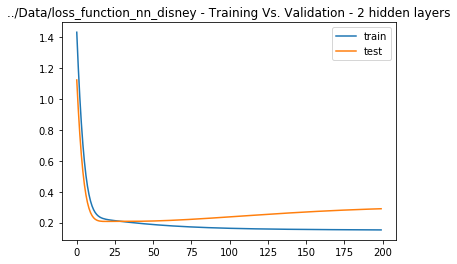

In [683]:
# Train vs test for deep net
plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("../Data/loss_function_nn_disney - Training Vs. Validation - 2 hidden layers")
plt.savefig('../Images/loss_function_nn_disney - Training Vs. Validation - 2 hidden layers.png')
plt.legend(["train", "test"])
plt.show()

In [684]:
import h5py

nn.save('../Models/disney_nn_loss_2_layers.h5')  # creates a HDF5 file 'my_model.h5'
del nn  # deletes the existing model

In [706]:
# Define the model - deep neural net
number_input_features = 4
hidden_nodes_layer1 = 12
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 3


nn = Sequential()
# First hidden layer
nn.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

In [719]:
# Compile model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
nn.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 12)                60        
_________________________________________________________________
dense_204 (Dense)            (None, 8)                 104       
_________________________________________________________________
dense_205 (Dense)            (None, 3)                 27        
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 4         
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


In [689]:
# Creating validation data sets
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False) 

In [721]:
# Fit the model
model_3 = nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=1, shuffle=False, epochs=200)

Train on 9 samples, validate on 5 samples
Epoch 1/200
9/9 [==============================] - 0s 30ms/sample - loss: 0.3889 - mse: 0.3889 - val_loss: 0.4965 - val_mse: 0.4965
Epoch 2/200
9/9 [==============================] - 0s 1ms/sample - loss: 0.3147 - mse: 0.3147 - val_loss: 0.4229 - val_mse: 0.4229
Epoch 3/200
9/9 [==============================] - 0s 1ms/sample - loss: 0.2660 - mse: 0.2660 - val_loss: 0.3716 - val_mse: 0.3716
Epoch 4/200
9/9 [==============================] - 0s 1ms/sample - loss: 0.2368 - mse: 0.2368 - val_loss: 0.3379 - val_mse: 0.3379
Epoch 5/200
9/9 [==============================] - 0s 1ms/sample - loss: 0.2207 - mse: 0.2207 - val_loss: 0.3164 - val_mse: 0.3164
Epoch 6/200
9/9 [==============================] - 0s 1ms/sample - loss: 0.2122 - mse: 0.2122 - val_loss: 0.3026 - val_mse: 0.3026
Epoch 7/200
9/9 [==============================] - 0s 1ms/sample - loss: 0.2077 - mse: 0.2077 - val_loss: 0.2933 - val_mse: 0.2933
Epoch 8/200
9/9 [=======================

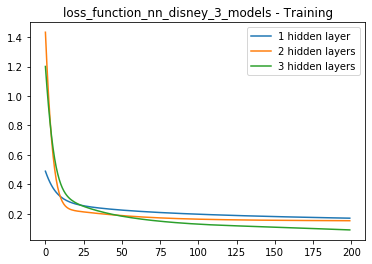

In [716]:
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.plot(model_3.history["loss"])

plt.title("loss_function_nn_disney_3_models - Training")
plt.legend(["1 hidden layer", "2 hidden layers", "3 hidden layers"])
plt.savefig('../Images/loss_function_nn_disney - Training - 3 hidden layers.png')
plt.show()

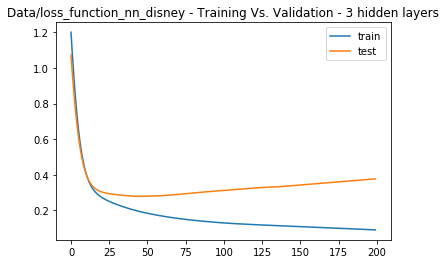

In [717]:
# Train vs test for deep net
plt.plot(model_3.history["loss"])
plt.plot(model_3.history["val_loss"])
plt.title("Data/loss_function_nn_disney - Training Vs. Validation - 3 hidden layers")
plt.legend(["train", "test"])
plt.savefig('../Images/loss_function_nn_disney - Training Vs. Validation - 3 hidden layer.png')
plt.show()

In [722]:
# Evaluate the model on the test data using `evaluate`
print(f'\n Evaluate on test data for 5-minute rolling positive prices sentiments:')
val_loss, val_mse = nn.evaluate(X, y, verbose=0)
print(f'\n For unshuffled valuation, test loss on 3-layer neural network model is Loss: {val_loss:,.4f}.')


 Evaluate on test data for 5-minute rolling positive prices sentiments:

 For unshuffled valuation, test loss on 3-layer neural network model is Loss: 0.2029.


In [723]:
# Make some predictions
# Make predictions using the testing data X_test
predicted = nn.predict(X)

In [726]:
real = y

In [727]:
# Create a DataFrame of Real and Predicted values
price_moves = pd.DataFrame({
    "Real": real.ravel(),
    "Predicted": predicted.ravel()
})
price_moves

,Real,Predicted
0,0,0.442079
1,0,0.057312
2,1,1.028403
3,0,-0.005891
4,0,0.100117
5,1,0.620261
6,1,0.453141
7,1,0.953010
8,0,0.337146
9,1,0.721791


In [728]:
# Transform Gender column
def changePredicted(predicted):
    if predicted >= 0.5:
        return 1
    else:
        return 0

price_moves["Predicted"] = price_moves["Predicted"].apply(changePredicted)
price_moves

,Real,Predicted
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,1,1
6,1,0
7,1,1
8,0,0
9,1,1


In [699]:
#TODO: To be replaced by dropdown widgets from maui_stock_data.ipynb
tickers = ['SPY','DJIA','AAPL', 'GOOG', 'FB', 'NFLX','DIS', 'MSFT', 'IBM']
ticker = input ("Enter ticker :") 

Enter ticker : DIS


<Figure size 432x288 with 0 Axes>

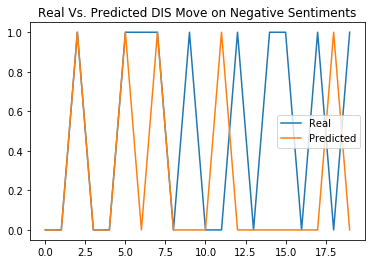

In [700]:
# Plot the real vs predicted values as a line chart
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
price_moves.plot(title=f"Real Vs. Predicted {ticker} Move on Negative Sentiments")
plt.savefig(f'../Images/{ticker}_real_vs_predicted_nn.png')
plt.show()

<Figure size 432x288 with 0 Axes>

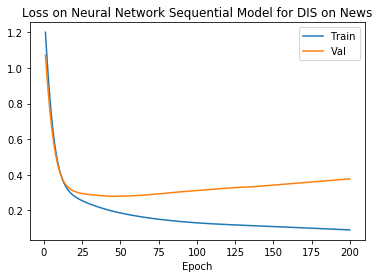

In [701]:
# Plotting loss
epochs = 200
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": model_3.history["loss"],
        "Val": model_3.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)

plt.figure()
loss_df.plot(title=f"Loss on Neural Network Sequential Model for {ticker} on News")
plt.savefig(f'../Images/{ticker}_loss_nn.png')
plt.show()

In [702]:
import h5py

nn.save('../Models/disney_nn_loss_3_layers.h5')  # creates a HDF5 file 'my_model.h5'
del nn  # deletes the existing model